In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [3]:
tf.random.set_seed(47)
np.random.seed(47)

In [4]:
# !pip install optuna > /dev/null

In [5]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [6]:
plt.rcParams['figure.figsize'] = (16,6)

In [7]:
df = pd.read_csv('../input/stockdata/ADBL_data.csv')
df['Date'] = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Open,High,Low,Close
0,2012-01-01,115.0,115.0,113.0,114.0
1,2012-01-02,114.0,118.0,115.0,118.0
2,2012-01-03,118.0,116.0,114.0,115.0
3,2012-01-04,115.0,115.0,113.0,114.0
4,2012-01-05,114.0,114.0,112.0,113.0


Using only Date and Close

In [9]:
df = df[['Date', 'Close']]

In [10]:
df.describe()

,Close
count,1911.00000
mean,406.92831
std,167.13069
min,101.00000
25%,313.00000
50%,420.00000
75%,480.00000
max,1082.00000


In [11]:
df.head()

,Date,Close
0,2012-01-01,114.0
1,2012-01-02,118.0
2,2012-01-03,115.0
3,2012-01-04,114.0
4,2012-01-05,113.0


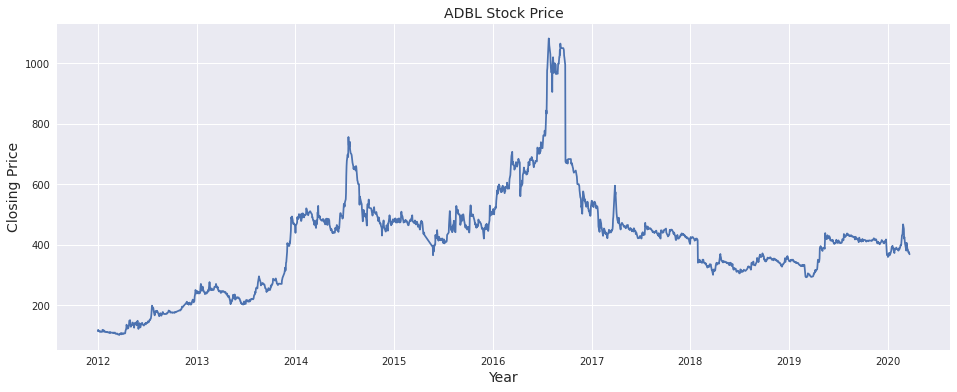

In [12]:
plt.title('ADBL Stock Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.plot(df['Date'], df['Close'])
plt.show()

# Generating features from target variable

In [13]:
# Percentage change is : (Todays price - yesterdays price) / yesterdays price
# For instance: (658.0 - 661.0) / 661.0
df['returns'] = df.Close.pct_change() * 100
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
df.head()

,Date,Close,returns
0,2012-01-02,118.0,3.508772
1,2012-01-03,115.0,-2.542373
2,2012-01-04,114.0,-0.869565
3,2012-01-05,113.0,-0.877193
4,2012-01-08,114.0,0.884956


In [15]:
data = df[['Close', 'returns']].values
data

array([[118.        ,   3.50877193],
       [115.        ,  -2.54237288],
       [114.        ,  -0.86956522],
       ...,
       [374.        ,  -1.05820106],
       [376.        ,   0.53475936],
       [368.        ,  -2.12765957]])

# Train, validation and test split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_data = train_test_split(data, test_size=0.20, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(1528, 2)
(191, 2)
(191, 2)


# Scaling input data

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Generating input features based on time step

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)


Train Samples: 1527
Validation Samples: 190
Test Samples: 190


# Scaling back output data to original Closing price

In [22]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [23]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(1527,) (190,) (190,)


In [24]:
x_train[1], y_train[0]

(array([[0.01427115, 0.70251106]]), 0.01427115188583078)

In [25]:
x_val[1], y_val[0]

(array([[0.23445464, 0.7485674 ]]), 0.23445463812436293)

In [26]:
x_test[1], y_test[0]

(array([[0.32008155, 0.75711126]]), 0.32008154943934763)

# LSTM Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras import optimizers

## Hyperparameter Search

In [28]:
early_stopping_rounds = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)

In [29]:
# Objective function
def run(trial):
    space = {        
        'optimizer':  trial.suggest_categorical('optimizer', [optimizers.Adam, optimizers.Adagrad, optimizers.Adamax, optimizers.Nadam, optimizers.RMSprop, optimizers.SGD]),
        'units': trial.suggest_int('units', 50, 4000, 50),
        'epochs': trial.suggest_int('epochs', 100, 5000, 50),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.6),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 8e-1)
    }

    model = Sequential()
    # Adding the LSTM layer and some Dropout regularization
    model.add(LSTM(units=space['units'], input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(rate=space['dropout_rate']))
    # Adding the output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(loss='mean_squared_error', optimizer=space['optimizer'](learning_rate=space['learning_rate']), metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=space['epochs'], validation_data=(x_val, y_val), batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_train = np.squeeze(model.predict(x_train))
    yhat_val = np.squeeze(model.predict(x_val))

    yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
    yhat_val = scaler.inverse_transform(prep_data_transform(yhat_val, X_val.shape[1]))[:,0]

    nan_check = [np.isnan(yhat_train).any(), np.isnan(yhat_val).any()]
    print(nan_check)
    if True in nan_check:
        rmse = 99999
    else:
        rmse = mean_squared_error(Y_val, yhat_val, squared=False)
    return rmse

In [30]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=50)

[I 2021-10-31 14:15:31,080] A new study created in memory with name: no-name-7db5cfb7-a802-4ff3-baf0-23e18b4a5c47
2021-10-31 14:15:31.157805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 14:15:31.246890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 14:15:31.247621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 14:15:31.249465: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critica

[False, False]


[I 2021-10-31 14:21:40,522] Trial 1 finished with value: 6.330301525248434 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 1900, 'epochs': 3050, 'batch_size': 32, 'dropout_rate': 0.3938648914484636, 'learning_rate': 0.0017036631453310209}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:28:12,386] Trial 2 finished with value: 11.116813196693295 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 2500, 'epochs': 750, 'batch_size': 32, 'dropout_rate': 0.4887018297694169, 'learning_rate': 0.05473820615876853}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:28:48,147] Trial 3 finished with value: 6.985735577342082 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 700, 'epochs': 4700, 'batch_size': 256, 'dropout_rate': 0.5966386780718461, 'learning_rate': 0.001470321859924576}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:29:09,345] Trial 4 finished with value: 7.30512480626792 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 400, 'epochs': 700, 'batch_size': 512, 'dropout_rate': 0.39331549912063, 'learning_rate': 0.020313374521571077}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:38:51,749] Trial 5 finished with value: 19.232123152748567 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 3350, 'epochs': 4300, 'batch_size': 512, 'dropout_rate': 0.30689183746414517, 'learning_rate': 0.6013063518607068}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:40:19,139] Trial 6 finished with value: 6.400162645284008 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 1500, 'epochs': 1350, 'batch_size': 64, 'dropout_rate': 0.5257382371131787, 'learning_rate': 0.17129587352252093}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:43:43,477] Trial 7 finished with value: 7.222498481447825 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 750, 'epochs': 3650, 'batch_size': 32, 'dropout_rate': 0.29533146584465175, 'learning_rate': 0.016582360197168747}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:47:07,198] Trial 8 finished with value: 7.200419207914913 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 250, 'epochs': 3450, 'batch_size': 32, 'dropout_rate': 0.45799964026484397, 'learning_rate': 0.22701970686007386}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:51:00,250] Trial 9 finished with value: 95.04151563911404 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 3700, 'epochs': 4650, 'batch_size': 64, 'dropout_rate': 0.35821509898157333, 'learning_rate': 0.33368102064775473}. Best is trial 1 with value: 6.330301525248434.


[False, False]


[I 2021-10-31 14:54:27,697] Trial 10 finished with value: 6.230618439723574 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 1600, 'epochs': 2300, 'batch_size': 16, 'dropout_rate': 0.15124823186921174, 'learning_rate': 0.0015493956856243716}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 14:58:36,602] Trial 11 finished with value: 6.455826073240914 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 1600, 'epochs': 2150, 'batch_size': 16, 'dropout_rate': 0.13856787880084787, 'learning_rate': 0.0011378867989972655}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:03:05,136] Trial 12 finished with value: 6.362656268142693 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 1750, 'epochs': 2400, 'batch_size': 16, 'dropout_rate': 0.10193226072017898, 'learning_rate': 0.0034289990963818494}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:11:42,634] Trial 13 finished with value: 7.009004561947155 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 2500, 'epochs': 3100, 'batch_size': 16, 'dropout_rate': 0.21838386640845664, 'learning_rate': 0.005188197911313479}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:12:27,177] Trial 14 finished with value: 6.7337387010519585 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 1150, 'epochs': 1850, 'batch_size': 256, 'dropout_rate': 0.20778935954414288, 'learning_rate': 0.002310814695231594}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:15:35,839] Trial 15 finished with value: 6.309354647707651 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 2100, 'epochs': 2950, 'batch_size': 128, 'dropout_rate': 0.24435316750417188, 'learning_rate': 0.00961042005613394}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:17:57,929] Trial 16 finished with value: 6.269889839994017 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3050, 'epochs': 2700, 'batch_size': 128, 'dropout_rate': 0.20266569477820873, 'learning_rate': 0.05191023384103501}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:20:45,478] Trial 17 finished with value: 6.263465765261082 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3100, 'epochs': 1400, 'batch_size': 128, 'dropout_rate': 0.1607197091356287, 'learning_rate': 0.05759803014804951}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:29:00,425] Trial 18 finished with value: 6.681922688383556 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 3950, 'epochs': 1700, 'batch_size': 16, 'dropout_rate': 0.14576377063390744, 'learning_rate': 0.05820488083749687}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:31:45,756] Trial 19 finished with value: 6.254823385830539 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3000, 'epochs': 1400, 'batch_size': 128, 'dropout_rate': 0.16660611331932734, 'learning_rate': 0.09443111823067388}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:35:57,197] Trial 20 finished with value: 16.073286292387117 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 2800, 'epochs': 1050, 'batch_size': 16, 'dropout_rate': 0.2769898896723677, 'learning_rate': 0.14119012088842145}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:38:24,847] Trial 21 finished with value: 6.241250564193537 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3400, 'epochs': 1450, 'batch_size': 128, 'dropout_rate': 0.16240218654705282, 'learning_rate': 0.09798824842834775}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:41:23,719] Trial 22 finished with value: 6.2419865994049335 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3500, 'epochs': 2100, 'batch_size': 128, 'dropout_rate': 0.10390113695056741, 'learning_rate': 0.09924832970906082}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:45:21,207] Trial 23 finished with value: 6.254791611680185 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3550, 'epochs': 2150, 'batch_size': 128, 'dropout_rate': 0.10030372874026745, 'learning_rate': 0.03271678878951892}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:46:14,190] Trial 24 finished with value: 11.196227934393972 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 1150, 'epochs': 1850, 'batch_size': 128, 'dropout_rate': 0.19041539641606436, 'learning_rate': 0.7464570736098408}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:48:01,219] Trial 25 finished with value: 6.262759269867446 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 3800, 'epochs': 2450, 'batch_size': 128, 'dropout_rate': 0.12224470965977219, 'learning_rate': 0.012030355937675034}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:50:25,476] Trial 26 finished with value: 6.269260660064124 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3350, 'epochs': 3650, 'batch_size': 512, 'dropout_rate': 0.23304659242221004, 'learning_rate': 0.14282837945378757}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:52:59,638] Trial 27 finished with value: 7.725832477610824 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 2250, 'epochs': 2150, 'batch_size': 64, 'dropout_rate': 0.26324355094639806, 'learning_rate': 0.3601666884224188}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:53:52,411] Trial 28 finished with value: 19.92918264215103 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 2750, 'epochs': 200, 'batch_size': 256, 'dropout_rate': 0.1768219728053777, 'learning_rate': 0.03201191655761892}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 15:54:44,387] Trial 29 finished with value: 6.342101264631911 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 1200, 'epochs': 950, 'batch_size': 128, 'dropout_rate': 0.3296419773824196, 'learning_rate': 0.10185564100510493}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 16:04:34,536] Trial 30 finished with value: 6.3054990367810495 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 3450, 'epochs': 400, 'batch_size': 16, 'dropout_rate': 0.13722947070672364, 'learning_rate': 0.008452277870956194}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 16:09:10,547] Trial 31 finished with value: 6.24587847119478 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3550, 'epochs': 2150, 'batch_size': 128, 'dropout_rate': 0.10809691179465694, 'learning_rate': 0.03526144491135837}. Best is trial 10 with value: 6.230618439723574.


[False, False]


[I 2021-10-31 16:14:26,951] Trial 32 finished with value: 6.2302252498247155 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3950, 'epochs': 2750, 'batch_size': 128, 'dropout_rate': 0.10462415968733087, 'learning_rate': 0.09962702925692794}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:17:33,515] Trial 33 finished with value: 6.264904955957387 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3700, 'epochs': 2800, 'batch_size': 128, 'dropout_rate': 0.16651387532344236, 'learning_rate': 0.07448782019520046}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:21:15,938] Trial 34 finished with value: 6.238014735400928 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3250, 'epochs': 3300, 'batch_size': 128, 'dropout_rate': 0.14368220678086568, 'learning_rate': 0.3039186221673797}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:23:30,039] Trial 35 finished with value: 213.3545257378677 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 4000, 'epochs': 3300, 'batch_size': 128, 'dropout_rate': 0.19236315403920617, 'learning_rate': 0.3805434208589828}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:25:13,202] Trial 36 finished with value: 6.25038679931631 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3200, 'epochs': 4100, 'batch_size': 512, 'dropout_rate': 0.1378965725167372, 'learning_rate': 0.22945957033501843}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:26:25,095] Trial 37 finished with value: 6.30287301302219 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 2750, 'epochs': 3950, 'batch_size': 256, 'dropout_rate': 0.2344502957311416, 'learning_rate': 0.46030163248248024}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:28:42,720] Trial 38 finished with value: 6.236517071736102 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2000, 'epochs': 2550, 'batch_size': 32, 'dropout_rate': 0.404093358994248, 'learning_rate': 0.22613098192955738}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:31:12,836] Trial 39 finished with value: 6.315382225727164 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2000, 'epochs': 2600, 'batch_size': 32, 'dropout_rate': 0.3953829298922985, 'learning_rate': 0.23159270814002775}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:35:45,324] Trial 40 finished with value: 6.7104149342994495 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2200, 'epochs': 3150, 'batch_size': 32, 'dropout_rate': 0.5219804484109511, 'learning_rate': 0.17944365027503228}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:37:23,341] Trial 41 finished with value: 8.324026109681725 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 1450, 'epochs': 3500, 'batch_size': 32, 'dropout_rate': 0.4183966205892231, 'learning_rate': 0.5232239938002338}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:42:53,009] Trial 42 finished with value: 6.2950705150248405 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 1850, 'epochs': 2850, 'batch_size': 32, 'dropout_rate': 0.44310680891905735, 'learning_rate': 0.2721908745112258}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:44:24,447] Trial 43 finished with value: 11.862603801956672 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 2400, 'epochs': 2450, 'batch_size': 64, 'dropout_rate': 0.3579998242928153, 'learning_rate': 0.023815930622213943}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 16:46:27,681] Trial 44 finished with value: 46.201592110282284 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 1400, 'epochs': 3300, 'batch_size': 32, 'dropout_rate': 0.4982979953159923, 'learning_rate': 0.11524521857205128}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 17:08:34,131] Trial 45 finished with value: 6.504389863605084 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3800, 'epochs': 3850, 'batch_size': 16, 'dropout_rate': 0.5704913612242188, 'learning_rate': 0.16702113393528464}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 17:09:23,781] Trial 46 finished with value: 6.413842744974317 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 2500, 'epochs': 1650, 'batch_size': 512, 'dropout_rate': 0.3806255821799759, 'learning_rate': 0.002015171954491031}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 17:10:48,324] Trial 47 finished with value: 6.230359136036541 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 800, 'epochs': 4500, 'batch_size': 128, 'dropout_rate': 0.30475495206767145, 'learning_rate': 0.0010056181455288288}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 17:14:35,529] Trial 48 finished with value: 8.200409617451355 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 600, 'epochs': 4500, 'batch_size': 16, 'dropout_rate': 0.31272643670405725, 'learning_rate': 0.0010392238300180035}. Best is trial 32 with value: 6.2302252498247155.


[False, False]


[I 2021-10-31 17:15:59,921] Trial 49 finished with value: 6.418112330080273 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 900, 'epochs': 4150, 'batch_size': 128, 'dropout_rate': 0.33761017430016377, 'learning_rate': 0.0014835794395916268}. Best is trial 32 with value: 6.2302252498247155.


[False, False]
CPU times: user 1h 50min 55s, sys: 10min 23s, total: 2h 1min 18s
Wall time: 3h 28s


In [31]:
best_params = study.best_params
best_params

{'optimizer': keras.optimizer_v2.gradient_descent.SGD,
 'units': 3950,
 'epochs': 2750,
 'batch_size': 128,
 'dropout_rate': 0.10462415968733087,
 'learning_rate': 0.09962702925692794}

In [32]:
# best_params = {
#     'optimizer': optimizers.Adam,
#     'units': 1350,
#     'epochs': 3400,
#     'batch_size': 256,
#     'dropout_rate': 0.2781339738750026,
#     'learning_rate': 0.0033161581408700184
# }

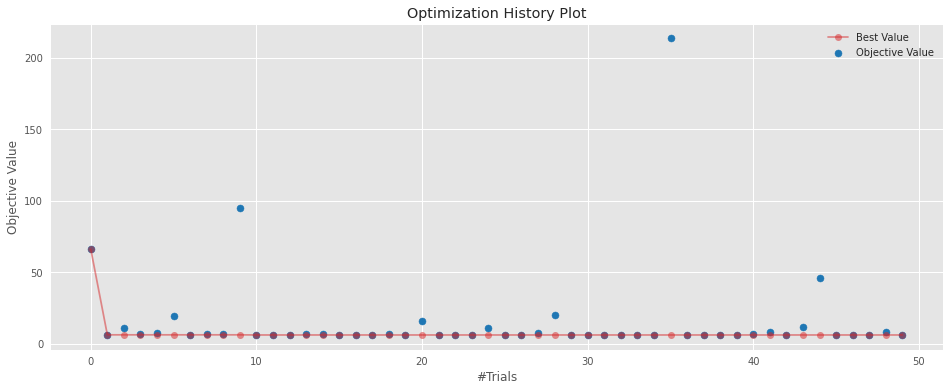

In [33]:
plot_optimization_history(study);

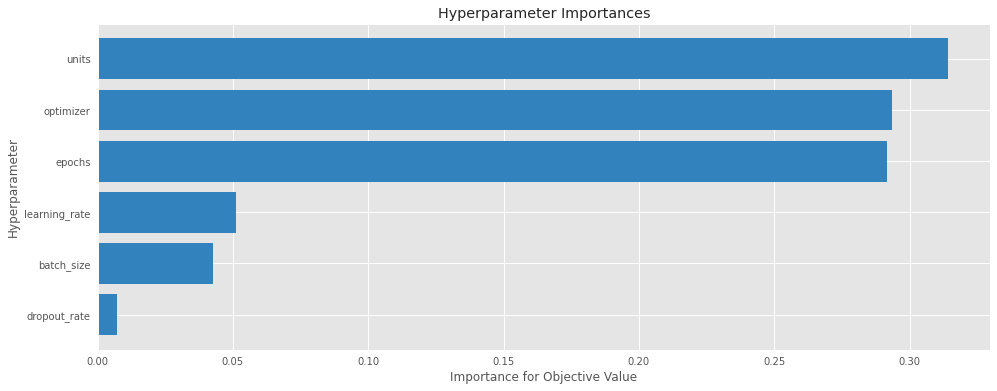

In [34]:
plot_param_importances(study);

In [35]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

## Model Training

In [36]:
model = Sequential()
model.add(LSTM(units=best_params['units'], input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=best_params['dropout_rate']))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=best_params['optimizer'](learning_rate=best_params['learning_rate']), metrics=['accuracy'])
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 3950)              62457400  
_________________________________________________________________
dropout_50 (Dropout)         (None, 3950)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 3951      
Total params: 62,461,351
Trainable params: 62,461,351
Non-trainable params: 0
_________________________________________________________________


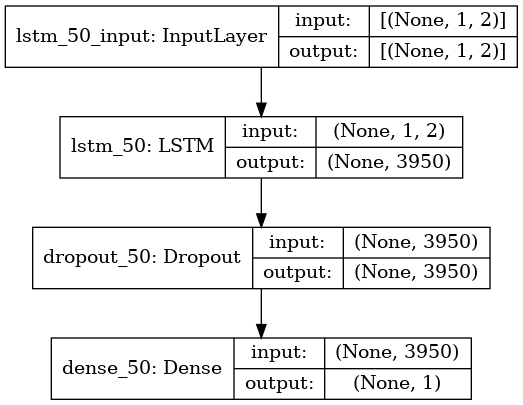

In [37]:
plot_model(model, show_shapes=True)

In [38]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 4min 36s, sys: 32 s, total: 5min 9s
Wall time: 13min 4s


## Model Evaluation

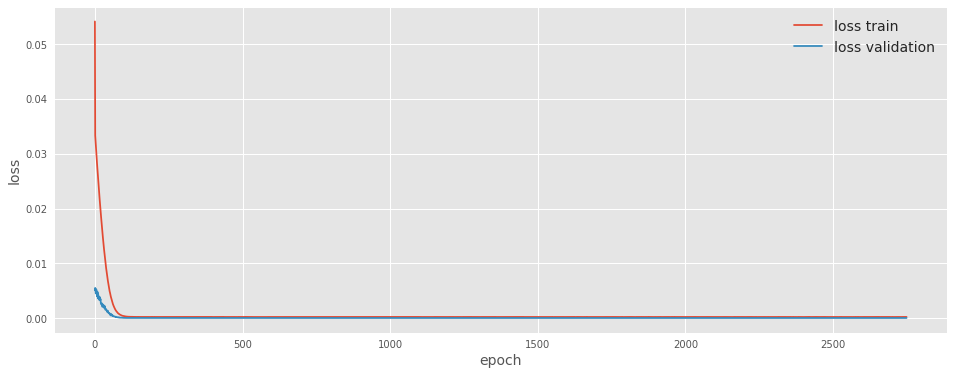

In [39]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [40]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

2/2 [==============================] - 0s 10ms/step - loss: 5.3993e-05 - accuracy: 0.0000e+00


[5.3993266192264855e-05, 0.0]

## Prediction

In [41]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

In [42]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(1527,) (190,)


In [43]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [120.6097779  115.43859174 115.04609373 114.04747701 115.67908772]
Train Actual:  [115. 114. 113. 114. 111.]
Test Predicted:  [416.50300968 415.06441921 410.81600773 403.57393879 403.10955292]
Test Actual:  [415. 411. 404. 403. 402.]


## Loss Analysis

In [44]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.46 RMSE
Test Score: 7.21 RMSE


## Plotting Predictions

In [45]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

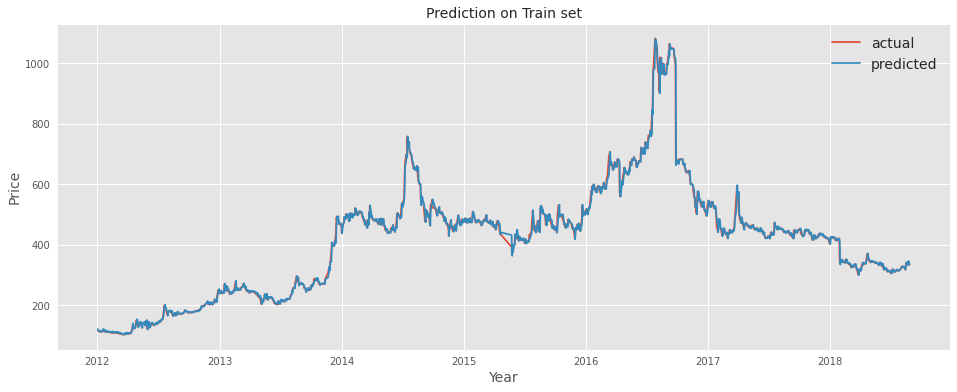

In [46]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

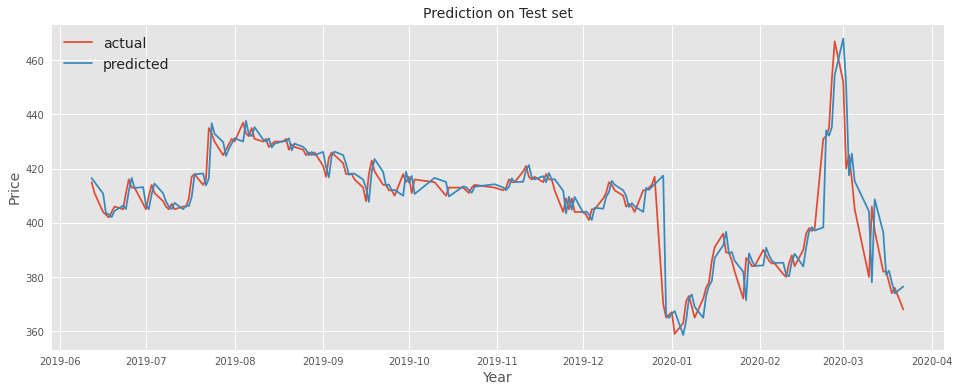

In [47]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()